<a href="https://colab.research.google.com/github/yebiny/SkillTreePython-DeepLearning/blob/main/04.Paper-with-code/comment/ch04_08_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ch04.08 Transformer

* 날짜:
* 이름:

## 학습내용
  - Transformer을 이해하고 구현한다.
  - Vision Transformer을 이해하고 구현한다.

## 참고 사이트

   - 논문 [Attention is all you need](https://arxiv.org/pdf/1706.03762.pdf)


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys, os
sys.path.append('/content/drive/MyDrive/scripts/')
from lib import *

## 모듈 제작
---

### **| Multi Head Attention**

<p align='center'>
<img src=https://github.com/yebiny/SkillTreePython-DeepLearning/blob/main/imgs/ch0408-09.PNG?raw=true?raw=true?raw=true
 width=350>
</p>

* set params

<p align='center'>
<img src=https://github.com/yebiny/SkillTreePython-DeepLearning/blob/main/imgs/ch0408-01.PNG?raw=true?raw=true
 width=850>
</p>


In [ ]:
h = 8 
d_k = 64
d_v  = 64
d_model = 64 * h #512  = embeding dims

# 인풋 x shape 
# 시계열 : ( time range(window_size), channel )
# 텍스트 : ( max lenth , vocab size )
# 텍스트 임베딩 : (max lenth, embeding dims)

# -> (V, K, Q)
# T = S = max lenth
# d_model = embedding dims
T = 200
S = 100

Q = (T, d_model)
K = (S, d_model)
V = (S, d_model)
print(Q)
print(K)
print(V)

(200, 512)
(100, 512)
(100, 512)


In [ ]:
def matmul(shape1, shape2):
  assert shape1[1]==shape2[0]
  return (shape1[0], shape2[1])
A = (100, 300)
B = (300, 200)
matmul(A, B)

(100, 200)

* Step1. Linear each  $Q, K, V(W^Q, W^K, W^V)$

<br>

<p align='center'>
<img src=https://github.com/yebiny/SkillTreePython-DeepLearning/blob/main/imgs/ch0408-05.PNG?raw=true?raw=true?raw=true
 width=250>
</p>

<p align='center'>
<img src=https://github.com/yebiny/SkillTreePython-DeepLearning/blob/main/imgs/ch0408-02-1.PNG?raw=true?raw=true
 width=850>
</p>



In [ ]:
# set weights
W_Q = (d_model, d_k)
W_K = (d_model, d_k)
W_V = (d_model, d_v) 

# calculate shape
VW = matmul(V, W_V) 
KW = matmul(K, W_K) 
QW = matmul(Q, W_Q) 

print(f'Q {Q} x W_Q {W_Q} = {QW}')
print(f'K {K} x W_K {W_K} = {KW}')
print(f'V {V} x W_V {W_V} = {VW}')

Q (200, 512) x W_Q (512, 64) = (200, 64)
K (100, 512) x W_K (512, 64) = (100, 64)
V (100, 512) x W_V (512, 64) = (100, 64)


* Step2. Attention


<p align='center'>
<img src=https://wikidocs.net/images/page/159310/mha_img_original.png?raw=true
 width=450>
</p>


<p align='center'>
<img src=https://github.com/yebiny/SkillTreePython-DeepLearning/blob/main/imgs/ch0408-03.PNG?raw=true?raw=true
 width=850>
</p>

In [ ]:
KW_T = (KW[1], KW[0])
print(f"QW: {QW}, KW_T: {KW_T}, VW: {VW}")

Att = matmul( matmul(QW, KW_T), VW )
print(f'Attention(QW, KW, VW) : {Att}')

QW: (200, 64), KW_T: (64, 100), VW: (100, 64)
Attention(QW, KW, VW) : (200, 64)


* step3. concat & Linear $(W^O)$

<p align='center'>
<img src=https://github.com/yebiny/SkillTreePython-DeepLearning/blob/main/imgs/ch0408-10.PNG?raw=true?raw=true?raw=true
 width=300>
</p>

<p align='center'>
<img src=https://github.com/yebiny/SkillTreePython-DeepLearning/blob/main/imgs/ch0408-04.PNG?raw=true?raw=true
 width=850>
</p>

In [ ]:
print(f'- Attention(QW, KW, VW) = head {Att}')

concat_att = (Att[0], Att[1]*h)
print(f'- Concat(head_1, ...head_h) {concat_att}')

W_O = ((h*d_v), d_model)
final_out = matmul(concat_att, W_O)
print(f'- Concat {concat_att} x W_O {W_O} = final output: {final_out}' )

- Attention(QW, KW, VW) = head (200, 64)
- Concat(head_1, ...head_h) (200, 512)
- Concat (200, 512) x W_O (512, 512) = final output: (200, 512)


In [ ]:
print('- 인풋: ',  V, K, Q)
print(f'- 최종 아웃풋: {final_out}')

- 인풋:  (100, 512) (100, 512) (200, 512)
- 최종 아웃풋: (200, 512)


#### Tensorflow.keras MultiHeadAttention Layer

* docs: https://www.tensorflow.org/api_docs/python/tf/keras/layers/MultiHeadAttention

```
tf.keras.layers.MultiHeadAttention(
    num_heads,
    key_dim,
    value_dim=None,
)

# call args

query	Query Tensor of shape (B, T, dim).
value	Value Tensor of shape (B, S, dim).
key	Optional key Tensor of shape (B, S, dim). If not given, will use 
```

In [ ]:
h = 8 
d_k = 64
d_model = 64 * h #512  = embeding dims

T = 200
S = 100

Q = layers.Input(shape=(T, d_model))
V = layers.Input(shape=(S, d_model))
K = layers.Input(shape=(S, d_model))

y = layers.MultiHeadAttention(num_heads = h,
                              key_dim = d_k,
                              )(Q, V)
                          

In [ ]:
print(f'- 인풋: V {V.shape} K {K.shape} Q {Q.shape}')
print(f'- 최종 아웃풋: {y.shape}')

AttributeError: ignored

### **| Encoder Block**

<p align='center'>
<img src=https://github.com/yebiny/SkillTreePython-DeepLearning/blob/main/imgs/ch0408-11.PNG?raw=true?raw=true
 width=250>
</p>

In [ ]:
def encoder_block(input_shape, h, d_k, d_ff, dropout=0.25, name=None):
    inputs = layers.Input(shape=input_shape)
    # Attention and Normalization
    # multi-head
    y = layers.MultiHeadAttention(num_heads= h,
                                  key_dim= d_k, 
                                  dropout= dropout)(inputs, inputs)
    y = layers.Dropout(dropout)(y)                        
    # Add & Norm
    y = layers.LayerNormalization(epsilon=1e-6)(y)
    y_1 = layers.Add()([y, inputs])

    # Feed Forward Part
    # FF
    y = layers.Conv1D(filters=d_ff, kernel_size=1, activation='relu')(y_1)
    y = layers.Dropout(dropout)(y)
    y = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1, activation='relu')(y)
    # Add & Norm
    y = layers.LayerNormalization(epsilon=1e-6)(y)
    outputs = layers.Add()([y, y_1])

    return models.Model(inputs, outputs, name=name)

In [ ]:
input_shape = (200, 128)
h = 8
d_k = 16
d_ff = 32
encoder = encoder_block(input_shape,
                        h, 
                        d_k, 
                        d_ff)
utils.plot_model(encoder, show_shapes=True)

## 실습1. 시계열 데이터 분류
---

### **| 시계열 데이터셋**

In [ ]:
def readucr(filename):
    data = np.loadtxt(filename, delimiter="\t")
    y = data[:, 0]
    x = data[:, 1:]
    return x, y.astype(int)


root_url = "https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/"

x_train, y_train = readucr(root_url + "FordA_TRAIN.tsv")
x_test, y_test = readucr(root_url + "FordA_TEST.tsv")

x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

n_classes = len(np.unique(y_train))

idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

y_train[y_train == -1] = 0
y_test[y_test == -1] = 0

(3601, 500, 1) (3601,)


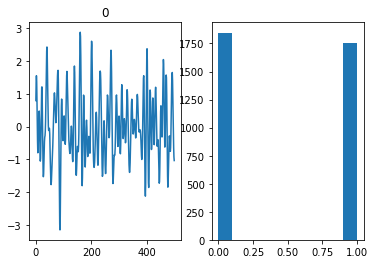

In [ ]:
print(x_train.shape, y_train.shape)

idx = 10
plt.subplot(121)
plt.title(y_train[idx])
plt.plot(x_train[idx])
plt.subplot(122)
plt.hist(y_train)
plt.show()


### **| 모델 구현**

In [ ]:
### Set params
input_shape = (500, 1) # ( T/S , d_model)
n_classes = 2

N = 4
h = 4
d_k = 128
d_ff = 4

### 모델 구현

# Set Input
inputs = layers.Input(shape=input_shape)

# Encoder Block
y = inputs
for i in range(N):
  encoder = encoder_block(input_shape, 
                          h, 
                          d_k, 
                          d_ff, 
                          name=f'encoder_{i}')
  y = encoder(y)

# Classifier
y = layers.GlobalAveragePooling1D(data_format='channels_first')(y)
y = layers.Dense(128, activation='relu')(y)
y = layers.Dropout(0.5)(y)
y = layers.Dense(n_classes, activation='softmax')(y)

# Final model
model = models.Model(inputs, y, name='TransformerEncoderCfy')
model.summary()

Model: "TransformerEncoderCfy"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_51 (InputLayer)       [(None, 500, 1)]          0         
                                                                 
 encoder_0 (Functional)      (None, 500, 1)            3602      
                                                                 
 encoder_1 (Functional)      (None, 500, 1)            3602      
                                                                 
 encoder_2 (Functional)      (None, 500, 1)            3602      
                                                                 
 encoder_3 (Functional)      (None, 500, 1)            3602      
                                                                 
 global_average_pooling1d_6   (None, 500)              0         
 (GlobalAveragePooling1D)                                        
                                             

In [ ]:
model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(0.0001),
              metrics='acc')
es = tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True)
model.fit(x_train, y_train,
          validation_data=[x_test, y_test],
          epochs = 50,
          batch_size=64,
          callbacks=[es])

Epoch 1/50
57/57 [==============================] - 28s 207ms/step - loss: 1.1684 - acc: 0.5176 - val_loss: 0.7986 - val_acc: 0.5591
Epoch 2/50
57/57 [==============================] - 11s 196ms/step - loss: 0.9287 - acc: 0.5648 - val_loss: 0.7021 - val_acc: 0.6053
Epoch 3/50
57/57 [==============================] - 11s 195ms/step - loss: 0.8524 - acc: 0.5862 - val_loss: 0.6504 - val_acc: 0.6439
Epoch 4/50
12/57 [=====>........................] - ETA: 7s - loss: 0.8128 - acc: 0.5964

## 실습2. IMDB 텍스트 분류
---

### **| IMDB 데이터셋**


In [ ]:
vocab_size = 20000  
maxlen = 200  

(x_train, y_train), (x_val, y_val) = tf.keras.datasets.imdb.load_data(num_words=vocab_size)
print(len(x_train), "Training sequences")
print(len(x_val), "Validation sequences")
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_val = tf.keras.preprocessing.sequence.pad_sequences(x_val, maxlen=maxlen)
print(x_train.shape, x_val.shape)

17473536/17464789 [==============================] - 0s 0us/step
25000 Training sequences
25000 Validation sequences
(25000, 200) (25000, 200)


In [ ]:
200 -> (200, embeing)

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    1,   14,   47,    8,   30,   31,    7,
          4,  249,  108,    7,    4, 5974,   54,   61,  369,   13,   71,
        149,   14,   22,  112,    4, 2401,  311,   12,   16, 3711,   33,
         75,   43, 1829,  296,    4,   86,  320,   35,  534,   19,  263,
       4821, 1301,    4, 1873,   33,   89,   78,   12,   66,   16,    4,
        360,    7,    4,   58,  316,  334,   11,    4, 1716,   43,  645,
        662,    8,  257,   85, 1200,   42, 1228, 2578,   83,   68, 3912,
         15,   36,  165, 1539,  278,   36,   69,    2,  780,    8,  106,
         14, 6905, 1338,   18,    6,   22,   12,  2

In [ ]:
# 데이터가 정하는 값
maxlen = 200
vocab_size = 20000
# 하이어파라미터
embed_dim = 128

x = layers.Input(shape = (maxlen,))
x_em = layers.Embedding(input_dim = vocab_size, 
                        output_dim = embed_dim )(x)
print(x.shape, x_em.shape)

(None, 200) (None, 200, 128)


In [ ]:
0: 오늘 , -> 0.2, 0.4, -2
1: 날씨가
2: 좋다.

In [ ]:
class TokenAndPositionEmbedding(layers.Layer): # 상속 : tf.keras의 Layer 를 상속받는다.
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__() # 부모 클래스의 초기값들을 가져오기
       
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim) # 기본 임베딩
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim) # Positional encoding
        self.maxlen = maxlen
    
    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [ ]:
x_embed = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)(x)
print(x_embed)

KerasTensor(type_spec=TensorSpec(shape=(None, 200, 32), dtype=tf.float32, name=None), name='token_and_position_embedding_28/add:0', description="created by layer 'token_and_position_embedding_28'")



### **| 모델 구현**

In [ ]:
encoder = encoder_block((100,100), 
                        h, 
                        d_k, 
                        d_ff, 
                        name=f'encoder_6')
encoder.summary()

Model: "encoder_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_52 (InputLayer)          [(None, 200, 128)]   0           []                               
                                                                                                  
 multi_head_attention_31 (Multi  (None, 200, 128)    66048       ['input_52[0][0]',               
 HeadAttention)                                                   'input_52[0][0]']               
                                                                                                  
 dropout_60 (Dropout)           (None, 200, 128)     0           ['multi_head_attention_31[0][0]']
                                                                                                  
 layer_normalization_60 (LayerN  (None, 200, 128)    256         ['dropout_60[0][0]']     

In [ ]:
### Set params
maxlen = 200
vocab_size = 20000
embed_dim = 32
n_classes = 2

N = 4
h = 4
d_k = 32
d_ff = 32

### 모델 구현

# Set Input
inputs = layers.Input(shape=(maxlen))

# Embedding : (maxlen) -> (maxlen, embed_dim)
y = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)(inputs)

# Encoder Block
for i in range(N):
  encoder = encoder_block(y.shape[1:], 
                          h, 
                          d_k, 
                          d_ff, 
                          name=f'encoder_{i}')
  y = encoder(y)

# Classifier
y = layers.GlobalAveragePooling1D(data_format='channels_first')(y)
y = layers.Dense(128, activation='relu')(y)
y = layers.Dropout(0.5)(y)
y = layers.Dense(n_classes, activation='softmax')(y)

# Final model
model = models.Model(inputs, y, name='TransformerEncoderCfy')
model.summary()

Model: "TransformerEncoderCfy"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_88 (InputLayer)       [(None, 200)]             0         
                                                                 
 token_and_position_embeddin  (None, 200, 32)          646400    
 g_30 (TokenAndPositionEmbed                                     
 ding)                                                           
                                                                 
 encoder_0 (Functional)      (None, 200, 32)           19040     
                                                                 
 encoder_1 (Functional)      (None, 200, 32)           19040     
                                                                 
 encoder_2 (Functional)      (None, 200, 32)           19040     
                                                                 
 encoder_3 (Functional)      (None, 200, 32) 

### **| 학습**

In [ ]:
model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(0.0001),
              metrics='acc')
es = tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True)
model.fit(x_train, y_train,
          validation_data=[x_val, y_val],
          epochs = 50,
          batch_size=32,
          callbacks=[es])

Epoch 1/50
782/782 [==============================] - 31s 33ms/step - loss: 0.6932 - acc: 0.4963 - val_loss: 0.6925 - val_acc: 0.5269
Epoch 2/50
782/782 [==============================] - 25s 32ms/step - loss: 0.4648 - acc: 0.7636 - val_loss: 0.3209 - val_acc: 0.8633
Epoch 3/50
782/782 [==============================] - 25s 32ms/step - loss: 0.2420 - acc: 0.9077 - val_loss: 0.3205 - val_acc: 0.8693
Epoch 4/50
782/782 [==============================] - 25s 32ms/step - loss: 0.1820 - acc: 0.9344 - val_loss: 0.3603 - val_acc: 0.8689
Epoch 5/50
782/782 [==============================] - 25s 32ms/step - loss: 0.1343 - acc: 0.9530 - val_loss: 0.4615 - val_acc: 0.8630
Epoch 6/50
782/782 [==============================] - 25s 32ms/step - loss: 0.1038 - acc: 0.9664 - val_loss: 0.4636 - val_acc: 0.8621
Epoch 7/50
782/782 [==============================] - 25s 32ms/step - loss: 0.0829 - acc: 0.9736 - val_loss: 0.5244 - val_acc: 0.8556
Epoch 8/50
782/782 [==============================] - 25s 32ms

## 실습3. Vision Transformer
---

In [3]:
def display_img_patches(img, patches=None):

  # origin image
  plt.imshow(img)
  plt.axis('off')
  plt.show()
 
  if patches is not None:
    n = int(np.sqrt(patches.shape[0]))
    patch_size = int(img.shape[0]/n)

    # patch imgs
    plt.figure(figsize=(4, 4))
    for i, patch in enumerate(patches):
      ax = plt.subplot(n, n, i + 1)
      patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
      plt.imshow(patch_img.numpy().astype("uint8"))
      plt.axis("off")
    plt.show()

    # patches
    plt.figure(figsize=(10, 2))
    for i, patch in enumerate(patches):
      ax = plt.subplot(1, n*n, i + 1)
      patch = tf.expand_dims(patch, 1)
      plt.imshow(patch.numpy().astype("uint8"))
      plt.axis("off")
    plt.show()

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data() # 100 개의 클래스 
x_train.shape, y_train.shape

169017344/169001437 [==============================] - 2s 0us/step


((50000, 32, 32, 3), (50000, 1))

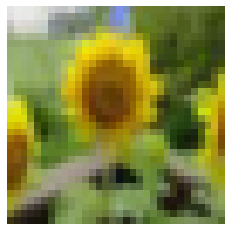

In [8]:
idx = 12
display_img_patches(x_train[idx])

### **| 이미지 증강**

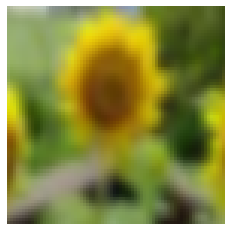

((32, 32, 3), TensorShape([72, 72, 3]))

In [25]:
def aug_model(resize=72):
                # 전처리
  aug_layers = [layers.Normalization(),  # 정규화 1/255
                layers.Resizing(resize, resize),  # 리사이즈 
                # 증강
                layers.RandomFlip(mode='horizontal'), # 랜덤플립
                layers.RandomRotation(factor=0.02), # 랜덤 회전
                layers.RandomZoom(height_factor=0.2, width_factor=0.2)] # 랜덤 확대

  model = tf.keras.Sequential(aug_layers, name='ImgAug')
  return model

# train / valid / test : train set에만 자동적으로 증강 레이어가 적용

x_img = x_train[idx]
x_aug = aug_model()(x_img)

display_img_patches(x_aug.numpy().astype('uint8'))
x_img.shape, x_aug.shape

### **| Patch 생성**

In [ ]:
x
layers.Dense(64)(input)

In [52]:
class MakePatchLayer(layers.Layer):
  def __init__(self, patch_size):
    super(MakePatchLayer, self).__init__()
    self.patch_size = patch_size

  def call(self, imgs): # (batch, h, w, ch)
    x_patches = tf.image.extract_patches( images = imgs,
                                          sizes = [1, self.patch_size, self.patch_size, 1],  
                                          strides = [1, self.patch_size, self.patch_size, 1],
                                          rates = [1, 1, 1, 1], 
                                          padding = 'VALID')
    # (batch_size, Hpatch개수 , Wpatch개수, patch 차원((patchsize**2)*3 ) )
    batch_size = tf.shape(x_patches)[0]
    d_patches = tf.shape(x_patches)[-1]

    x_patches = tf.reshape(x_patches, [batch_size, -1 , d_patches] )
    # (batch_size, patch 개수, patch 차원)
    return x_patches

(1, 72, 72, 3) (1, 36, 432)


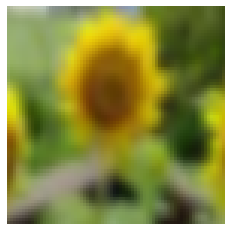

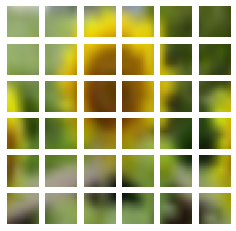

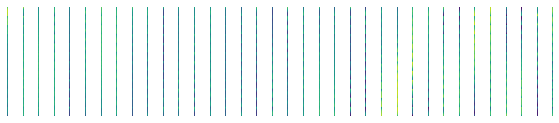

In [53]:
x_patches = MakePatchLayer(12)(x_aug)
print(x_aug.shape, x_patches.shape)
display_img_patches(x_aug[0].numpy().astype('uint8'), x_patches[0])

### **| Patch Encoder**

In [61]:
project_dim = 128
num_patches = tf.shape(x_patches)[1]
print(f'- flatten patches: {x_patches.shape}')

# patch linear projection
projected = layers.Dense(project_dim)(x_patches)
print(f'- projected patches: {projected.shape}')

# position embedding
positions = tf.range(0, num_patches, 1)
print(f'- positions: {positions}, num_patches: {num_patches}')
embed = layers.Embedding(num_patches, project_dim)(positions)
print(f'- embed postions: {embed.shape}')

# position+patch encoding
encoded = projected + embed
print(f'- encoding result: {encoded.shape}')

- flatten patches: (1, 36, 432)
- projected patches: (1, 36, 128)
- positions: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35], num_patches: 36
- embed postions: (36, 128)
- encoding result: (1, 36, 128)


In [63]:
class PatchPositionEncoder(layers.Layer):
  def __init__(self, project_dim, num_patches):
    super(PatchPositionEncoder, self).__init__()
    self.project_dim = project_dim
    self.num_patches = num_patches
    
    self.dense = layers.Dense(project_dim)
    self.embedding = layers.Embedding(num_patches, project_dim)

  def call(self, patches): # (batch, h, w, ch)
    # patch linear projection
    projected = self.dense(patches)

    # position embedding
    positions = tf.range(0, self.num_patches, 1)
    embed = self.embedding(positions)

    # position+patch encoding
    encoded = projected + embed
    return encoded

encoded = PatchPositionEncoder(128, 36)(x_patches)
print(x_patches.shape, encoded.shape)

(1, 36, 432) (1, 36, 128)



### **| 모델 구현**

In [ ]:
def encoder_block(input_shape, h, d_k, d_ff, dropout=0.25, name=None):
    inputs = layers.Input(shape=input_shape)
    # Attention and Normalization
    # multi-head
    y = layers.MultiHeadAttention(num_heads= h,
                                  key_dim= d_k, 
                                  dropout= dropout)(inputs, inputs)
    y = layers.Dropout(dropout)(y)                        
    # Add & Norm
    y = layers.LayerNormalization(epsilon=1e-6)(y)
    y_1 = layers.Add()([y, inputs])

    # Feed Forward Part
    # FF
    y = layers.Conv1D(filters=d_ff, kernel_size=1, activation='relu')(y_1)
    y = layers.Dropout(dropout)(y)
    y = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1, activation='relu')(y)
    # Add & Norm
    y = layers.LayerNormalization(epsilon=1e-6)(y)
    outputs = layers.Add()([y, y_1])

    return models.Model(inputs, outputs, name=name)

In [ ]:
# Set params


# Set Input


# Encoder Block


# Classifier

# Final model
